# Australian Grand Prix 2024

In [249]:
import numpy as np
import fastf1
import fastf1.plotting
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from fastf1.core import Laps
from timple.timedelta import strftimedelta
from fastf1.ergast import Ergast
import plotly.express as px
from plotly.io import show
fastf1.plotting.setup_mpl()
import sys
import warnings
warnings.filterwarnings("ignore")

In [107]:
sys.path.insert(0, "../")
from settings import CACHE_FOLDER_PATH
from utlis import *

In [108]:
setup_cache(CACHE_FOLDER_PATH)

In [109]:
session = fastf1.get_session(2024, 'Melbourne', 'R')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


In [110]:
laps = session.laps

![Bahrain Circuit](https://media.formula1.com/image/upload/f_auto/q_auto/v1677244985/content/dam/fom-website/2018-redesign-assets/Circuit%20maps%2016x9/Australia_Circuit.png.transform/5col-retina/image.png)

It's already the third round and we'll take a look at the scored points to this points 

In [111]:
ergast = Ergast()
races = ergast.get_race_schedule(2024)  # Races in the year 2024
results = []

In [112]:
for rnd, race in races['raceName'].items():
    race_results = ergast.get_race_results(season=2024, round=rnd + 1)
    if race_results.content: 
        temp = race_results.content[0]


        sprint_results = ergast.get_sprint_results(season=2024, round=rnd + 1)
        if sprint_results.content and sprint_results.description['round'][0] == rnd + 1:
            temp = pd.merge(temp, sprint_results.content[0], on='driverCode', how='left')
            temp['points'] = temp['points_x'] + temp['points_y']
            temp.drop(columns=['points_x', 'points_y'], inplace=True)

        temp['round'] = rnd + 1
        temp['race'] = race.removesuffix(' Grand Prix')
        temp = temp[['round', 'race', 'driverCode', 'points']]  
        results.append(temp)


results = pd.concat(results)
races = results['race'].drop_duplicates()

pivot = results.pivot_table(index='round', columns='driverCode', values='points', aggfunc='sum').fillna(0).cumsum()
zero_row = pd.DataFrame(0, index=[0], columns=pivot.columns)
new_pivot = pd.concat([zero_row, pivot])

new_pivot.reset_index(drop = True, inplace=True)

In [113]:
races_list = races.tolist()
races_list.insert(0, "Start")
races = pd.Series(races_list)

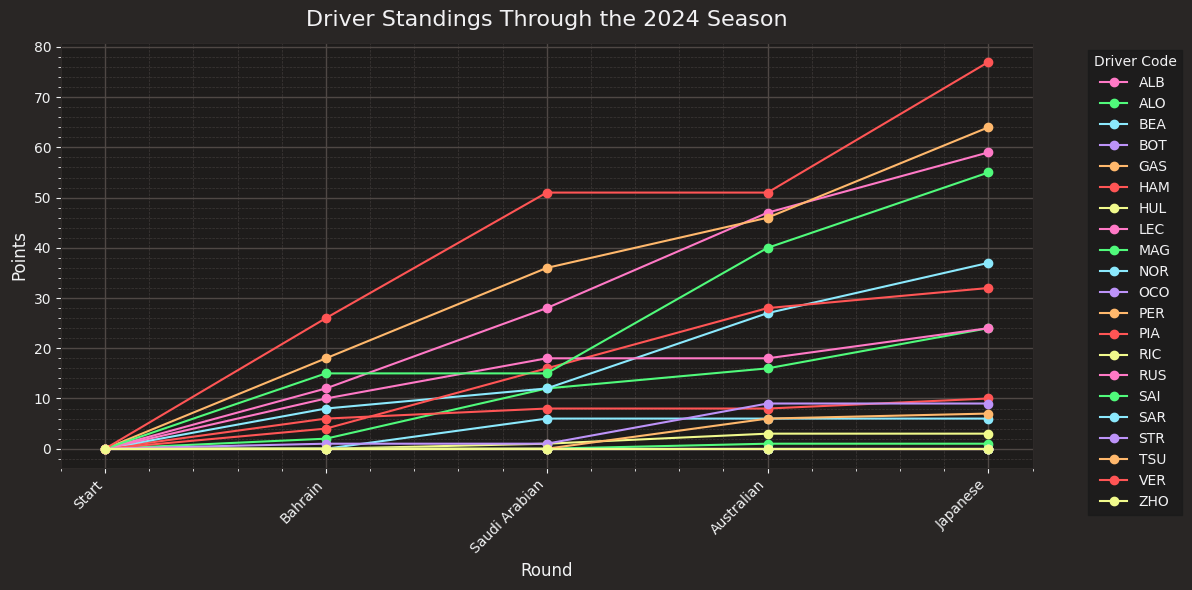

In [114]:
fig, ax = plt.subplots(figsize=(12, 6))
for column in new_pivot.columns:
    ax.plot(new_pivot.index, new_pivot[column], marker='o', label=column)

ax.set_xticks(range(len(races)))
ax.set_xticklabels(races, rotation=45, ha='right')

ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Points', fontsize=12)
ax.set_title('Driver Standings Through the 2024 Season', fontsize=16)
ax.grid(True)
ax.legend(title='Driver Code', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Bokeh example 

In [151]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, WheelZoomTool, ResetTool, Legend
from bokeh.layouts import column
from bokeh.io import show

output_notebook(hide_banner = True)

In [193]:
data = {
    'rounds': [str(x) for x in races] 
}

for column in new_pivot.columns:
    data[column] = new_pivot[column].tolist()

source = ColumnDataSource(data=data)

driver_colors = {driver: ff1.plotting.driver_color(driver) for driver in new_pivot.columns}

p = figure(x_range=data['rounds'], width=800, height=400, title='Driver Standings Through the 2024 Season',
           tools=[HoverTool(), WheelZoomTool(), ResetTool()],)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Round", "@rounds"),
    ("Driver", "$name"),  
    ("Points", "@$name")  
]

p.title.text_font = "arial"
p.xaxis.axis_label_text_font = "arial"
p.yaxis.axis_label_text_font = "arial"

p.title.text_font_size = '22pt'

for driver in new_pivot.columns:
    p.line('rounds', driver, source=source, line_width=2, color=driver_colors[driver])
    p.scatter('rounds', driver, source=source,  marker='circle', size=8, fill_color=driver_colors[driver], name=driver)

p.xaxis.axis_label = 'Round'
p.yaxis.axis_label = 'Points'
p.axis.axis_label_text_font_style = 'bold'
p.axis.major_label_orientation = "horizontal"
p.grid.grid_line_alpha = 0.3

p.legend.location = "top_left"
p.legend.title = 'Driver Code'

show(p)


# Drivers Result 

In [251]:
session

2024 Season Round 3: Australian Grand Prix - Race

In [252]:

def plot_race_results(session,session_name, figsize=(12, 5), dpi=300):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Plot driver positions
    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        abb = drv_laps['Driver'].iloc[0]
        color = ff1.plotting.driver_color(abb)

        ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                label=abb, color=color)
    
    # Add starting positions on the left side of the plot
    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        abb = drv_laps['Driver'].iloc[0]
        starting_position = int(drv_laps['Position'].iloc[0])
        ax.text(0.8, drv_laps['Position'].iloc[0], f"P{starting_position}: {abb} ", color='w', ha='right')
    
    # Add final positions and places gained on the right side of the plot
    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        abb = drv_laps['Driver'].iloc[0]
        final_position = drv_laps['Position'].iloc[-1]
        starting_position = int(drv_laps['Position'].iloc[0])
        places_gained = int(starting_position - final_position)
        places_text =  f"({'+' if places_gained > 0 else '' if places_gained == 0 else '-'}{abs(places_gained)})"
        ax.text(57, final_position, f"P{starting_position}:{abb} {places_text}", color='w', ha='left') 

    # Add annotation for track position on the left side
    ax.annotate('Track Position', xy=(-0.11, 0.4), xycoords='axes fraction', fontsize=14, color='w', rotation=90)

    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([])
    ax.set_xlabel('Lap Number', fontsize=14)
    ax.set_xlim([1, 57])
    plt.title(f'2024 {session_name} Grand Prix', font='Arial', fontweight='bold', fontsize=24)
    plt.tight_layout()
    plt.show()

ValueError: cannot convert float NaN to integer

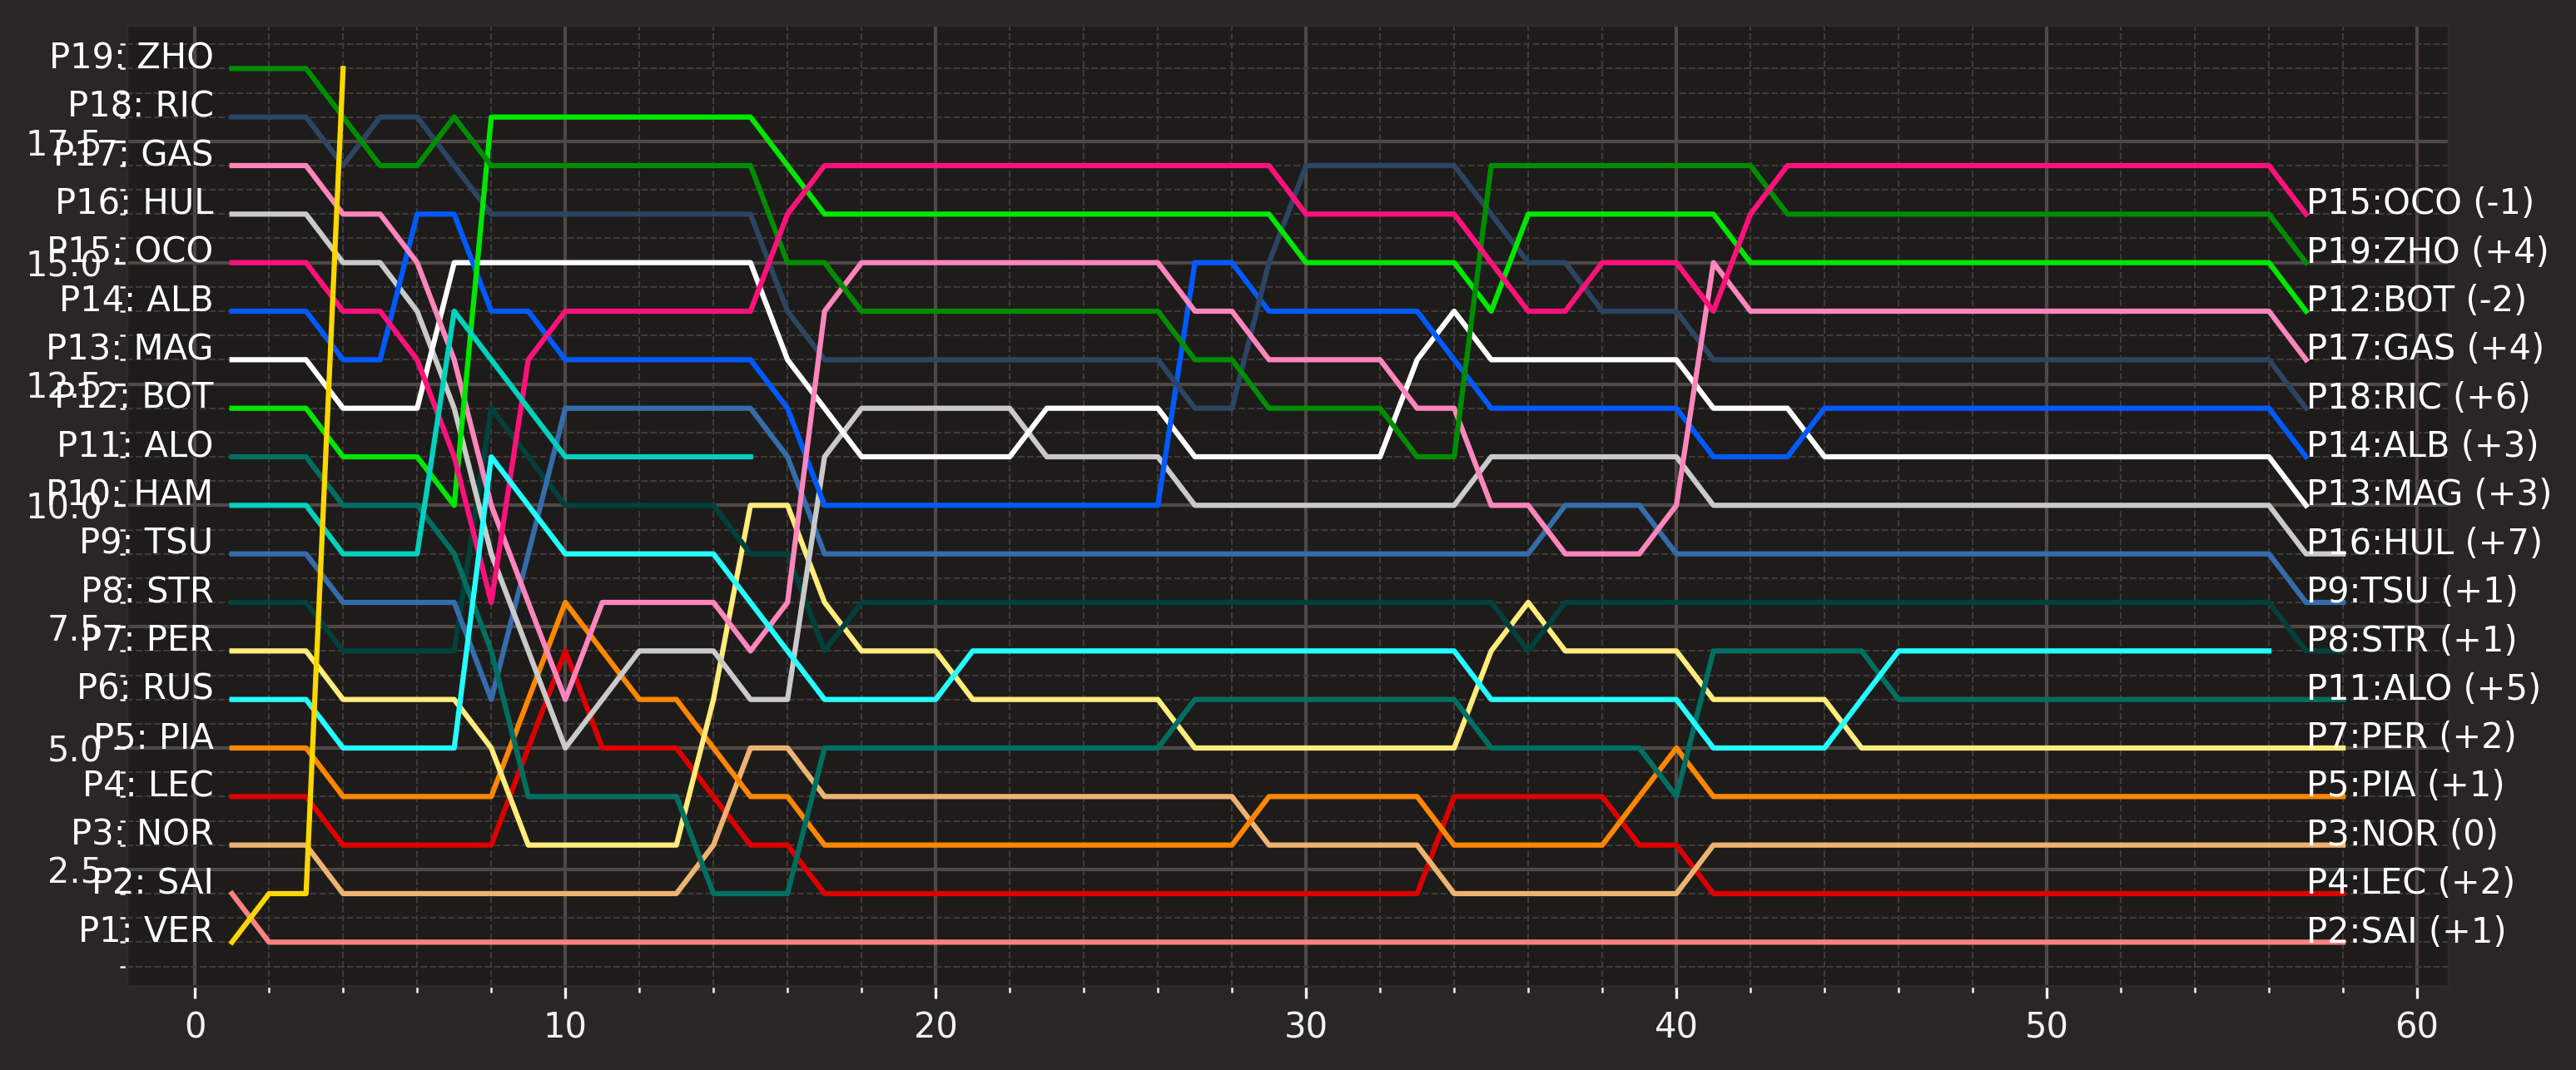

In [254]:
plot_race_results(session, 'melbourne')

# Team Mates Scatter Plot Comparison 

In [241]:
lec = session.laps.pick_driver("LEC").pick_quicklaps().reset_index()
sai = session.laps.pick_driver("SAI").pick_quicklaps().reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


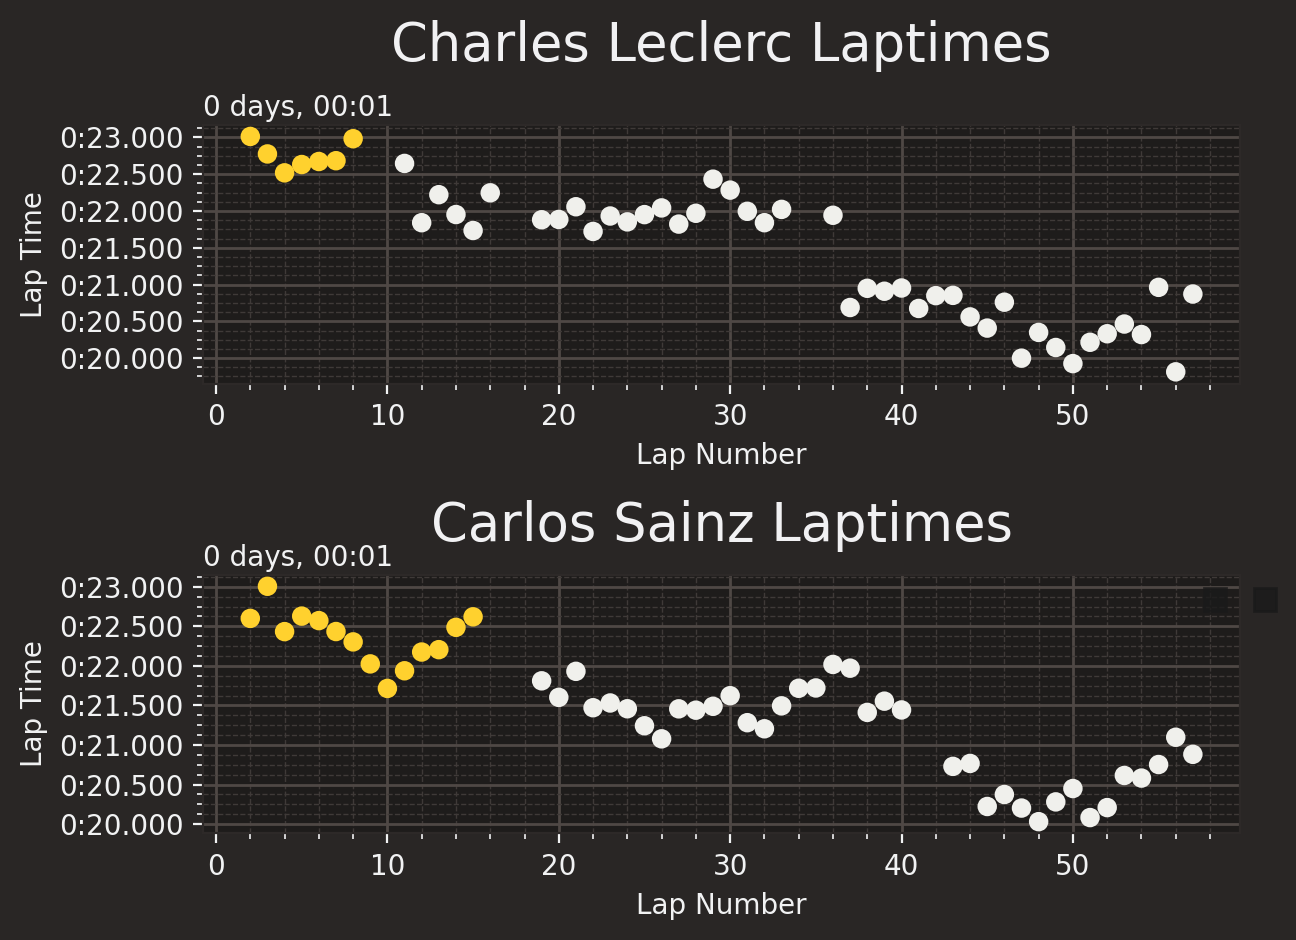

In [294]:
fig, (ax1, ax2)= plt.subplots(2,1, dpi = 200 )
ax1.scatter( lec['LapNumber'], lec['LapTime'],c = lec['Compound'].map(fastf1.plotting.COMPOUND_COLORS))
ax1.set_xlabel("Lap Number")
ax1.set_ylabel("Lap Time")
ax1.set_title("Charles Leclerc Laptimes")

ax2.scatter(sai['LapNumber'], sai['LapTime'], c=sai['Compound'].map(fastf1.plotting.COMPOUND_COLORS))
ax2.set_xlabel("Lap Number")
ax2.set_ylabel("Lap Time")
ax2.set_title("Carlos Sainz Laptimes")

fig.legend(loc='upper left', bbox_to_anchor=(1,1), bbox_transform=ax2.transAxes)

plt.legend()
plt.tight_layout()

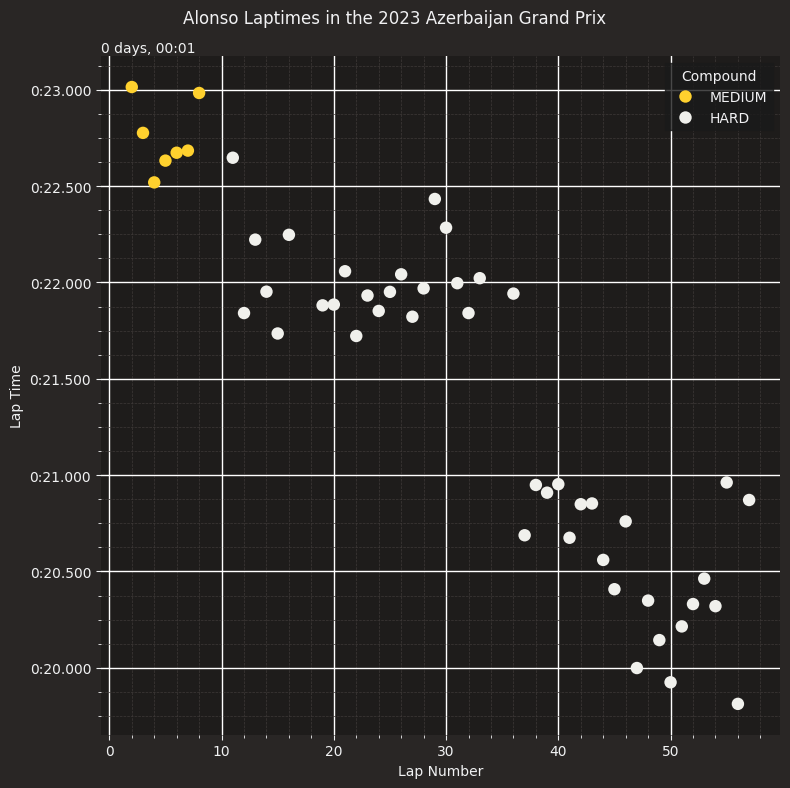

In [296]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=lec,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                s=80,
                linewidth=0,
                legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
ax.invert_yaxis()
plt.suptitle("Alonso Laptimes in the 2023 Azerbaijan Grand Prix")

plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

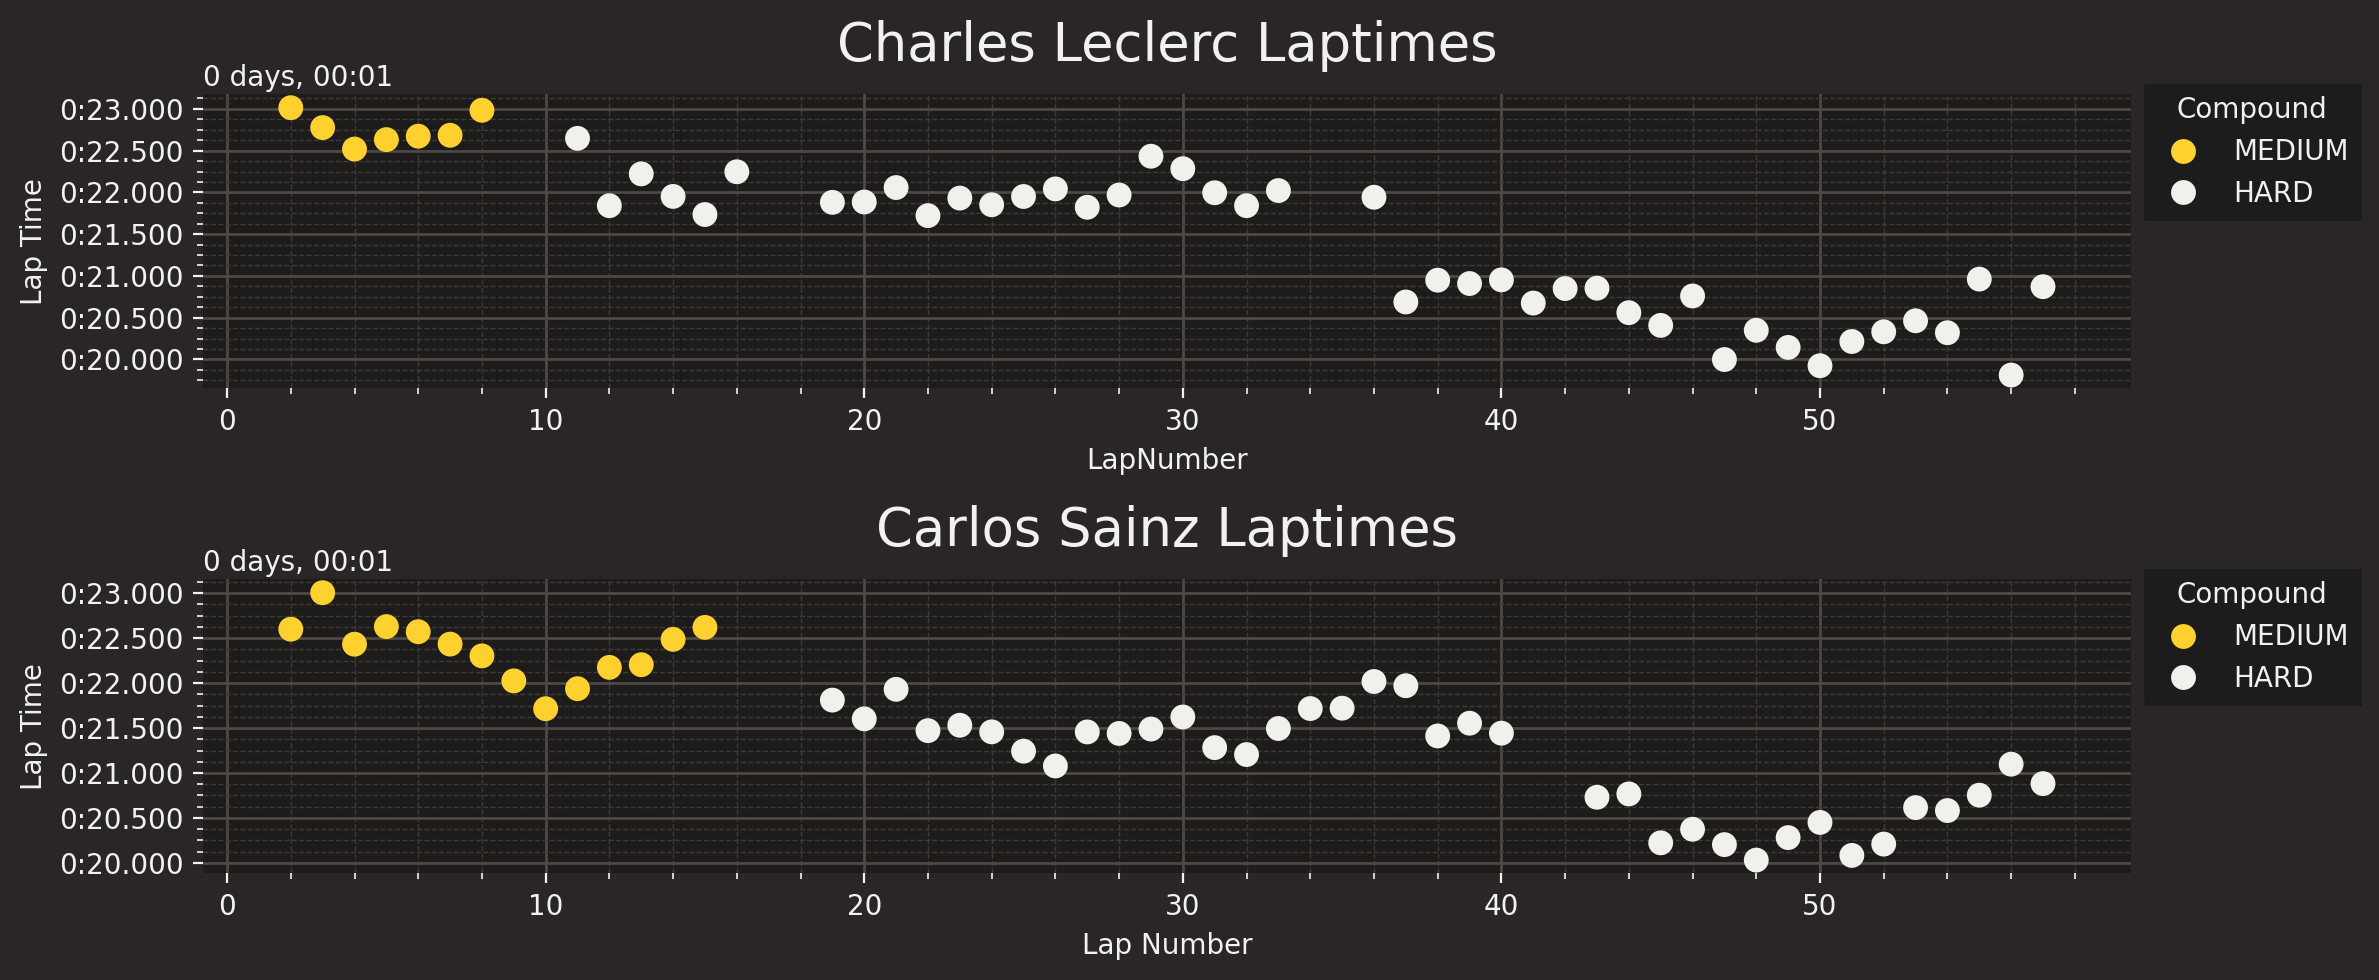

In [322]:
fig, (ax1,ax2)= plt.subplots(2,1,figsize=(12, 5), dpi = 200)

sns.scatterplot(data=lec,
                x="LapNumber",
                y="LapTime",
                ax=ax1,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                s=80,
                linewidth=0)

ax1.set_ylabel("Lap Time")
ax1.invert_yaxis()
ax1.set_title("Charles Leclerc Laptimes")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=labels, title="Compound", loc="upper left",  bbox_to_anchor=(1, 1.078))

sns.scatterplot(data=sai,
                x="LapNumber",
                y="LapTime",
                ax=ax2,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                s=80,
                linewidth=0)

ax2.set_xlabel("Lap Number")
ax2.set_ylabel("Lap Time")
ax2.invert_yaxis()
ax2.set_title("Carlos Sainz Laptimes")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=labels, title="Compound", loc="upper left",  bbox_to_anchor=(1, 1.078))

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
